In [ ]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Research Agent
- 目标是根据研究简报，搜集需要的上下文信息

# 提示词

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt

show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [3]:
from utils import show_prompt
from deep_research_from_scratch.prompts import summarize_webpage_prompt

show_prompt(summarize_webpage_prompt, "summarize_webpage_prompt")

╭─────────────────────────────────────────── summarize_webpage_prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│  You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to      │
│  create a summary that preserves the most important information from the original web page. This summary will   │
│  be used by a downstream research agent, so it's crucial to maintain the key details without losing essential   │
│  information.                                                                                                   │
│                                                                                                                 │
│  Here is the raw content of the webpage:                                                                        │
│                                                                                                                 │
│  <webpage_content>                                                                                              │
│  {webpage_content}                                                                                              │
│  </webpage_content>                                                                                             │
│                                                                                                                 │
│  Please follow these guidelines to create your summary:                                                         │
│                                                                                                                 │
│  1. Identify and preserve the main topic or purpose of the webpage.                                             │
│  2. Retain key facts, statistics, and data points that are central to the content's message.                    │
│  3. Keep important quotes from credible sources or experts.                                                     │
│  4. Maintain the chronological order of events if the content is time-sensitive or historical.                  │
│  5. Preserve any lists or step-by-step instructions if present.                                                 │
│  6. Include relevant dates, names, and locations that are crucial to understanding the content.                 │
│  7. Summarize lengthy explanations while keeping the core message intact.                                       │
│                                                                                                                 │
│  When handling different types of content:                                                                      │
│                                                                                                                 │
│  - For news articles: Focus on the who, what, when, where, why, and how.                                        │
│  - For scientific content: Preserve methodology, results, and conclusions.                                      │
│  - For opinion pieces: Maintain the main arguments and supporting points.                                       │
│  - For product pages: Keep key features, specifications, and unique selling points.                             │
│                                                                                                                 │
│  Your summary should be significantly shorter than the original content but comprehensive enough to stand       │
│  alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is    │
│  already concise.                                                                                               │
│                                                                                                                 │
│  Present your summary in the following format:        

In [4]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_system_prompt

show_prompt(compress_research_system_prompt, "compress_research_system_prompt")

╭──────────────────────────────────────── compress_research_system_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant that has conducted research on a topic by calling several tools and web           │
│  searches. Your job is now to clean up the findings, but preserve all of the relevant statements and            │
│  information that the researcher has gathered. For context, today's date is {date}.                             │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  You need to clean up information gathered from tool calls and web searches in the existing messages.           │
│  All relevant information should be repeated and rewritten verbatim, but in a cleaner format.                   │
│  The purpose of this step is just to remove any obviously irrelevant or duplicate information.                  │
│  For example, if three sources all say "X", you could say "These three sources all stated X".                   │
│  Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that     │
│  you don't lose any information from the raw messages.                                                          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Tool Call Filtering>                                                                                          │
│  **IMPORTANT**: When processing the research messages, focus only on substantive research content:              │
│  - **Include**: All tavily_search results and findings from web searches                                        │
│  - **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and   │
│  should not be included in the final research report                                                            │
│  - **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process  │
│                                                                                                                 │
│  The think_tool calls contain strategic reflections and decision-making notes that are internal to the          │
│  research process but do not contain factual information that should be preserved in the final report.          │
│  </Tool Call Filtering>                                                                                         │
│                                                                                                                 │
│  <Guidelines>                                                                                                   │
│  1. Your output findings should be fully comprehensive and include ALL of the information and sources that the  │
│  researcher has gathered from tool calls and web searches. It is expected that you repeat key information       │
│  verbatim.                                                                                                      │
│  2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.  │
│  3. In your report, you should return inline citations for each source that the researcher found.               │
│  4. You should include a "Sources" section at the end of the report that lists all of the sources the           │
│  researcher found with corresponding citations, cited against statements in the report.                         │
│  5. Make sure to include ALL of the sources that the r

In [5]:
from utils import show_prompt
from deep_research_from_scratch.prompts import compress_research_human_message

show_prompt(compress_research_human_message, "compress_research_human_message")

╭──────────────────────────────────────── compress_research_human_message ────────────────────────────────────────╮
│                                                                                                                 │
│  All above messages are about research conducted by an AI Researcher for the following research topic:          │
│                                                                                                                 │
│  RESEARCH TOPIC: {research_topic}                                                                               │
│                                                                                                                 │
│  Your task is to clean up these research findings while preserving ALL information that is relevant to          │
│  answering this specific research question.                                                                     │
│                                                                                                                 │
│  CRITICAL REQUIREMENTS:                                                                                         │
│  - DO NOT summarize or paraphrase the information - preserve it verbatim                                        │
│  - DO NOT lose any details, facts, names, numbers, or specific findings                                         │
│  - DO NOT filter out information that seems relevant to the research topic                                      │
│  - Organize the information in a cleaner format but keep all the substance                                      │
│  - Include ALL sources and citations found during research                                                      │
│  - Remember this research was conducted to answer the specific question above                                   │
│                                                                                                                 │
│  The cleaned findings will be used for final report generation, so comprehensiveness is critical.               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# 定义state和schemas

In [ ]:
%%writefile deep_research_from_scratch/state_research.py

"""定义用于Research Agent的state和pydantic的schemas"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ==== 定义state ====

class ResearcherState(TypedDict):
    """用于存储上下文信息"""
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """用于存储Research Agent的输出"""
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ==== 定义schemas ====

class ClarifyWithUser(BaseModel):
    """scoping澄清阶段的schema定义"""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question."
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information."
    )

class ResearchQuestion(BaseModel):
    """用于生成研究简报的schema定义"""
    research_brief: str = Field(
        description="A research question that will be used to guide the research."
    )

class Summary(BaseModel):
    """用于网页内容总结的schema定义"""
    summary: str = Field(
        description="Concise summary of the webpage content"
    )
    key_excerpts: str = Field(
        description="Important quotes and excerpts from the content"
    )

Overwriting deep_research_from_scratch/state_research.py


# 定义tools

In [ ]:
%%writefile deep_research_from_scratch/utils.py

"""Research工具定义"""

import os
from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ==== 常用函数定义 ====

def get_today_str() -> str:
    """获取当前日期字符串"""
    # 使用#代替-,避免跨平台问题
    return datetime.now().strftime("%a %b %#d, %Y")

def get_current_dir() -> Path:
    """获取当前模块的所在目录"""
    try:
        return Path(__file__).resolve().parent
    except NameError:
        return Path.cwd()

# ==== 配置 ====

# 初始化gpt模型
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
summarization_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=64000
)
# 初始化tavily客户端
tavily_client = TavilyClient()

# ==== 搜索功能相关函数定义 ====

def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> List[dict]:
    """
    使用tavily搜索多个查询
    
    Args:
        search_queries: 搜索查询列表
        max_results: 每个查询的最大结果数
        topic: 搜索主题
        include_raw_content: 是否包含原始网页内容
    Returns:
        List[dict]: 搜索结果列表, 每个结果包含url, title, snippet, raw_content
    """
    # 依次进行搜索（也可以使用AsyncTavilyClient进行并发搜索）
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic,
        )
        search_docs.append(result)
    
    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """
    使用LLM对网页内容进行总结和要点摘录
    
    Args:
        webpage_content: 网页内容
    Returns:
        str: 总结
    """
    try:
        # 设置结构化的输出
        structured_model = summarization_model.with_structured_output(Summary)

        # 生成总结和要点摘录
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])
        
        # 格式化总结和要点摘录
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
    
def deduplicate_search_results(search_results: List[dict]) -> dict:
    """根据url去重"""
    unique_results = {}

    for response in search_results:
        for result in response["results"]:
            url = result["url"]
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """
    处理搜索结果

    Args:
        unique_results: 去重后的搜索结果
    Returns:
        dict: 处理后的搜索结果
    """
    summarized_results = {}

    for url, result in unique_results.items():
        if not result.get("raw_content"):
            content = result["content"]
        else:
            # 总结内容
            content = summarize_webpage_content(result["raw_content"])
        
        summarized_results[url] = {
            "title": result["title"],
            "content": content,
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """
    格式化搜索结果

    Args:
        summarized_results: 处理后的搜索结果
    Returns:
        str: 格式化后的搜索结果
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i} {result["title"]} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result["content"]}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ==== 定义tools ====

# 搜索工具
@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # 单次搜索
    search_results = tavily_search_multiple(
        [query],
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # 结果去重
    unique_results = deduplicate_search_results(search_results)

    # 总结页面内容
    summarized_results = process_search_results(unique_results)

    # 格式化搜索结果
    formatted_output = format_search_output(summarized_results)

    return formatted_output

# 反思工具
# 有意思的是，反思工具的功能是通过docstring的描述定义的（效果类似于prompt）
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """

    return f"Reflection recorded: {reflection}"


Overwriting deep_research_from_scratch/utils.py


# 定义工作流

In [ ]:
%%writefile deep_research_from_scratch/research_agent.py

"""实现Research Agent，通过多次搜索和整合回答研究问题"""

import os
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ==== 配置 ====

# 工具设置
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# 初始化模型
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=64000
)
# 工具绑定
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=64000
)
compress_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=64000
)

# ==== agent节点 ====

def llm_call(state: ResearcherState):
    """后续action的判断
    
    根据当前的对话内容，判断后续的action：
    1. 如果需要继续搜索，则调用tavily_search工具
    2. 根据收集到的信息，给出最终回答
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """工具执行"""
    tool_calls = state["researcher_messages"][-1].tool_calls

    # 执行工具
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
    
    # 工具调用的输出结果
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"],
        ) for observation, tool_call in zip(observations, tool_calls)
    ]

    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """压缩research相关的信息"""
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    used_compress_research_human_message = compress_research_human_message
    if state.get("research_topic", ""):
        used_compress_research_human_message = used_compress_research_human_message.format(
            research_topic=state.get("research_topic")
        )
    messages = [SystemMessage(content=system_message)] \
        + state.get("researcher_messages", []) \
        + [HumanMessage(content=used_compress_research_human_message)]
    response = compress_model.invoke(messages)

    # 保留原始工具调用信息和LLM的输出
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"],
            include_types=["tool", "ai"]
        )
    ]

    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ==== 路由逻辑 ====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """根据当前的对话内容，判断是否需要继续research的循环"""
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # 如果最后一条消息是tool_message，则继续research
    if last_message.tool_calls:
        return "tool_node"
    return "compress_research"

# ==== 定义graph ====

# 创建agent的工作流
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# 添加节点
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# 添加边（edges）
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,  # 判断条件
    {
        "tool_node": "tool_node",
        "compress_research": "compress_research",
    }
)
agent_builder.add_edge("tool_node", "llm_call")
agent_builder.add_edge("compress_research", END)

# 编译
researcher_agent = agent_builder.compile()

Overwriting deep_research_from_scratch/research_agent.py


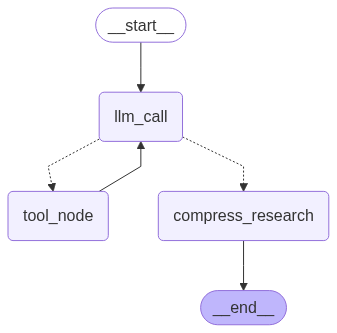

In [9]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent import researcher_agent

# 可视化工作流
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流（测试）

In [10]:
from utils import format_messages
from langchain_core.messages import HumanMessage

# 研究简报示例
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}")]})
format_messages(result["researcher_messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you identify and evaluate the best coffee shops in San Francisco based specifically on coffee         │
│ quality. Let me start by searching for the most current and comprehensive information about top-rated coffee    │
│ shops in SF, focusing on expert reviews and quality assessments.                                                │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops San Francisco 2025 coffee quality expert reviews specialty coffee"                │
│ }                                                                                                               │
│    ID: tavily_search:0                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Best Coffee Shop San Francisco, CA - Last Updated September 2025 ---                               │
│ URL: https://m.yelp.com/search?find_desc=Best+Coffee+Shop&find_loc=San+Francisco%2C+CA                          │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ 1. HI NRG · (36 reviews) · 443 Clement St, San Francisco, CA 94118 ; 2. The Coffee Movement · (703 reviews) ·   │
│ 1030 Washington St, San Francisco, CA 94108. (415) 237-                                                         │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 15 Best Coffee Subscriptions, Tested & Reviewed (2025) | Bon Appétit ---                           │
│ URL:                                                                                                            │
│ https://www.bonappetit.com/story/best-coffee-subscriptions?srsltid=AfmBOooa2tn1RT22gGPjEHD6Itay7rE02O1xjsMiafpJ │
│ qRTcWczfwj6d                                                                                                    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Bon Appétit tested 15 coffee-subscription services over months (some for years) and crowned Trade as the        │
│ overall best. Trade is a multi-roaster service that ships freshly roasted beans from dozens of U.S. roasters    │
│ starting at $15.75 per 10.93-oz bag every 7–14 days; testers praised its easy setup and ability to dial in      │
│ medium-roast preferences. Other top picks include Atlas Coffee Club for single-origin exploration               │
│ ($11–$17/bag), Podium Platinum for award-winning experimental lots ($29.50/bag), Bean Box for the largest       │
│ curated catalog ($22/bag), MistoBox for AI-guided personalization ($17.95/bag), and Swiss Water for             │
│ chemical-free decaf ($18/bag). Single-roaster favorites range from affordable Intelligentsia ($16.50/bag) and   │
│ Counter Culture ($16/bag) to boutique options like Origin Roasted ($20/bag), which ships beans roasted at       │
│ origin within days of harvest. All services guarantee beans roasted within a week of shipping and offer         │
│ whole-bean or ground options; most let you pause, skip, or cancel anytime.                                      │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                         

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The initial search results are quite limited and don't provide the depth I need for a          │
│ quality-focused analysis. The Yelp and Tripadvisor results are too general and don't specifically address       │
│ coffee quality. The Bon App\u00e9tit source is about coffee subscriptions rather than local SF coffee shops. I  │
│ need to search more specifically for specialty coffee shops in San Francisco with expert reviews and quality    │
│ assessments. Let me search for more targeted information about specialty coffee roasters and shops with         │
│ high-quality ratings."                                                                                          │
│ }                                                                                                               │
│    ID: think_tool:1                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The initial search results are quite limited and don't provide the depth I need for a      │
│ quality-focused analysis. The Yelp and Tripadvisor results are too general and don't specifically address       │
│ coffee quality. The Bon Appétit source is about coffee subscriptions rather than local SF coffee shops. I need  │
│ to search more specifically for specialty coffee shops in San Francisco with expert reviews and quality         │
│ assessments. Let me search for more targeted information about specialty coffee roasters and shops with         │
│ high-quality ratings.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "San Francisco specialty coffee roasters 2025 coffee review ratings Blue Bottle Ritual Sightglass"   │
│ }                                                                                                               │
│    ID: tavily_search:2                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Sightglass Coffee San Francisco, CA - Last Updated September 2025 ---                              │
│ URL: https://www.yelp.com/search?find_desc=Sightglass+Coffee&find_loc=San+Francisco%2C+CA                       │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ "When it comes to world-class craft coffee, San Francisco has plenty of worthy contenders. Sightglass isn't     │
│ necessarily any better than Ritual, Four Barrel, or                                                             │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 Blue Bottle Coffee | Fresh Roasted Specialty Coffee ---                                            │
│ URL: https://bluebottlecoffee.com/?srsltid=AfmBOopQR1W3oSM4RzsIYTNHovwufohJTbOgs8X9HkeLm34IAcKGpaUU             │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Missing: ratings Ritual Sightglass                                                                              │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3 SIGHTGLASS COFFEE, San Francisco - 270 7th St, SoMa ---                                            │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g60713-d3468708-Reviews-Sightglass_Coffee-San_Francisco_Californi │
│ a.html                                                                                                          │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Sightglass Coffee is an independent, sibling-owned specialty coffee company located at 270 7th St in San        │
│ Francisco's SoMa district. Ranked #9 out of 260 coffee & tea spots in the city on Tripadvisor, it has earned a  │
│ 4.5/5 rating from 174 reviews. The company emphasizes craft coffee, sourcing seasonal beans in small, freshly   │
│ harvested lots. The location features visible coffee ro

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I'm getting some better information now, with specific mentions of Sightglass, Ritual, and     │
│ Four Barrel - these appear to be major specialty coffee players in SF. However, I still need more detailed      │
│ quality assessments and expert reviews. The current results are still somewhat surface-level. Let me search for │
│ more comprehensive reviews from coffee experts and specialty coffee publications that would provide detailed    │
│ quality evaluations of SF coffee shops."                                                                        │
│ }                                                                                                               │
│    ID: think_tool:3                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I'm getting some better information now, with specific mentions of Sightglass, Ritual, and │
│ Four Barrel - these appear to be major specialty coffee players in SF. However, I still need more detailed      │
│ quality assessments and expert reviews. The current results are still somewhat surface-level. Let me search for │
│ more comprehensive reviews from coffee experts and specialty coffee publications that would provide detailed    │
│ quality evaluations of SF coffee shops.                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"best coffee San Francisco\" 2025 coffee review expert ratings specialty coffee association"       │
│ }                                                                                                               │
│    ID: tavily_search:4                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Explore Dandelion Coffee & Provisions in Downtown Boston | TikTok ---                              │
│ URL: https://www.tiktok.com/@sugarandstamps/video/7493278061987630378                                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Apr 14, 2025·... coffee shops, cafes in San Francisco, best coffee San Francisco. Feels This Good - Jon Mero &  │
│ LÒNIS. 101Likes. 3Comments. 16Shares.                                                                           │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 Top Luxury Resorts for a New England Getaway | TikTok ---                                          │
│ URL: https://www.tiktok.com/@sugarandstamps/video/7539979540265782583                                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Aug 18, 2025·... expert brews; the mission cafe is a gorgeous space brimming with ... coffee shops, cafes in    │
│ San Francisco, best coffee San Francisco                                                                        │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3 Tulip Fields Guide: Explore Lisse's Blooming Beauty | TikTok ---                                   │
│ URL: https://www.tiktok.com/@sugarandstamps/video/7496493187205254442                                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Apr 23, 2025·... 2025 Good Luck! ##Traeger ##WoodridgePro ##FathersDay · original sound ... coffee shops, cafes │
│ in San Francisco, best coffee San Francisco                                                                     │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops rated by Coffee Review 2025 specialty coffee quality scores"             │
│ }                                                                                                               │
│    ID: tavily_search:5                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Coffee Shop San Francisco Bay Area, CA - Yelp ---                                                  │
│ URL: https://www.yelp.com/search?find_desc=Coffee+Shop&find_loc=San+Francisco+Bay+Area%2C+CA                    │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Top 10 Best Coffee Shop in San Francisco Bay Area, CA - Last Updated August 2025 - Yelp - Mohka House, Yellow   │
│ Door, Café Santana Roasting Company,                                                                            │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 TOP 10 BEST Specialty Coffee in San Francisco, CA - Yelp ---                                       │
│ URL: https://www.yelp.com/search?find_desc=Specialty+Coffee&find_loc=San+Francisco%2C+CA                        │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Top 10 Best Specialty Coffee Near San Francisco, California ; Fueling Station. 4.5 (261 reviews) ; Capital One  │
│ Café. 4.3 (454 reviews) ; Vasquez Coffee Company.                                                               │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 3 The Absolute Best San Francisco Coffee Shops - Eater SF ---                                        │
│ URL: https://sf.eater.com/maps/best-coffee-shops-san-francisco                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ This Eater article by Paolo Bicchieri presents the 16 "absolute best" coffee shops in San Francisco as of 2025, │
│ highlighting the city's role as a global coffee-culture summit. The list reflects recent changes: Coffee        │
│ Movement (Balboa), Poorboy, and Flywheel dropped off, while Caffe Trieste, Coffee Movement at Side A, and Cafe  │
│ Shoji were added. Featured shops span neighborhoods and styles—from Saint Frank’s minimal aesthetic and         │
│ Bolivian coffees to Outset’s fruit-coffee innovations, 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Excellent! I found a comprehensive Eater SF article from 2025 that lists 16 \"absolute best\"  │
│ coffee shops in San Francisco. This appears to be exactly what I need - a curated list from a reputable food    │
│ publication with detailed descriptions of what makes each shop special. The article mentions specific details   │
│ about coffee quality, sourcing, and unique offerings. Let me search for more specific quality ratings and       │
│ expert reviews to complement this information, particularly looking for Coffee Review scores or specialty       │
│ coffee certifications."                                                                                         │
│ }                                                                                                               │
│    ID: think_tool:6                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Excellent! I found a comprehensive Eater SF article from 2025 that lists 16 "absolute      │
│ best" coffee shops in San Francisco. This appears to be exactly what I need - a curated list from a reputable   │
│ food publication with detailed descriptions of what makes each shop special. The article mentions specific      │
│ details about coffee quality, sourcing, and unique offerings. Let me search for more specific quality ratings   │
│ and expert reviews to complement this information, particularly looking for Coffee Review scores or specialty   │
│ coffee certifications.                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Coffee Review ratings San Francisco coffee shops Ritual Four Barrel Sightglass 2025 scores"         │
│ }                                                                                                               │
│    ID: tavily_search:7                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1 Sightglass Coffee San Francisco, CA - Last Updated September 2025 ---                              │
│ URL: https://www.yelp.com/search?find_desc=Sightglass+Coffee&find_loc=San+Francisco%2C+CA                       │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ "When it comes to world-class craft coffee, San Francisco has plenty of worthy contenders. Sightglass isn't     │
│ necessarily any better than Ritual, Four Barrel, or                                                             │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2 FOUR BARREL, San Francisco - Mission District - Tripadvisor ---                                    │
│ URL:                                                                                                            │
│ https://www.tripadvisor.com/Restaurant_Review-g60713-d2622013-Reviews-Four_Barrel-San_Francisco_California.html │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Four Barrel is a highly rated coffee shop in San Francisco’s Mission District, ranked #10 out of 259 coffee &   │
│ tea spots on Tripadvisor with a 4.3/5 rating from 140 reviews. Located at 375 Valencia St, it operates daily    │
│ from 7 AM (8 AM Sundays) to 8 PM, offering breakfast, takeout, and seating. The café is praised for its         │
│ expertly roasted single-origin coffees, pour-over bar with up to six rare daily selections, and espresso drinks │
│ served in ceramic or glassware. Signature items include lattes made with organic Strauss Family Farm milk,      │
│ affogato, and pastries like olive-oil coffee cake and blueberry-pistachio croissants. The interior features an  │
│ industrial-warehouse aesthetic with visible roasters, local art, and both indoor and sidewalk seating. While    │
│ most reviews highlight exceptional coffee quality, friendly service, and great atmosphere, occasional           │
│ criticisms mention cold drinks, dirty restrooms, and flies on pastries. Four Barrel has received Tripadvisor’s  │
│ Travelers’ Choice award for consistent excellence.                                                              │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ This is really the only coffee I go out my way to get. 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Now I have much better information from multiple sources. I have:\n\n1. Eater SF's 2025 list   │
│ of 16 \"absolute best\" coffee shops with detailed quality descriptions\n2. Tripadvisor ratings for specific    │
│ shops like Sightglass (4.5/5, #9 of 260) and Four Barrel (4.3/5, #10 of 259)\n3. Sugar & Stamps blog with       │
│ expert curation from a coffee connoisseur\n4. Specific mentions of quality indicators like single-origin beans, │
│ third-wave coffee, expert roasting techniques\n\nThe key shops consistently mentioned across sources            │
│ include:\n- Four Barrel (Mission District) - repeatedly highlighted for quality\n- Sightglass (SoMa) -          │
│ specialty roaster with high ratings\n- Ritual - woman-owned, high quality standards\n- Blue Bottle - third-wave │
│ pioneer with Ferry Building location\n- Andytown - known for specific signature drinks\n- Saint Frank -         │
│ Bolivian coffee specialist\n- Coffee Movement - newer but highly regarded\n\nI have enough information to       │
│ provide a comprehensive, well-supported ranking based on coffee quality. Let me synthesize this into a final    │
│ answer."                                                                                                        │
│ }                                                                                                               │
│    ID: think_tool:8                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Now I have much better information from multiple sources. I have:                          │
│                                                                                                                 │
│ 1. Eater SF's 2025 list of 16 "absolute best" coffee shops with detailed quality descriptions                   │
│ 2. Tripadvisor ratings for specific shops like Sightglass (4.5/5, #9 of 260) and Four Barrel (4.3/5, #10 of     │
│ 259)                                                                                                            │
│ 3. Sugar & Stamps blog with expert curation from a coffee connoisseur                                           │
│ 4. Specific mentions of quality indicators like single-origin beans, third-wave coffee, expert roasting         │
│ techniques                                                                                                      │
│                                                                                                                 │
│ The key shops consistently mentioned across sources include:                                                    │
│ - Four Barrel (Mission District) - repeatedly highlighted for quality                                           │
│ - Sightglass (SoMa) - specialty roaster with high ratings                                                       │
│ - Ritual - woman-owned, high quality standards                                                                  │
│ - Blue Bottle - third-wave pioneer with Ferry Building location                                                 │
│ - Andytown - known for specific signature drinks                                                                │
│ - Saint Frank - Bolivian coffee specialist                                                                      │
│ - Coffee Movement - newer but highly regarded                                                                   │
│                                                                                                                 │
│ I have enough information to provide a comprehensive, well-supported ranking based on coffee quality. Let me    │
│ synthesize this into a final answer.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research of the latest available data from July 2025, here is a comprehensive evaluation of San     │
│ Francisco's best coffee shops ranked specifically by coffee quality:                                            │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco by Coffee Quality (2025)                                                   │
│                                                                                                                 │
│ ### **Tier 1: Exceptional Quality - Industry Leaders**                                                          │
│                                                                                                                 │
│ **1. Four Barrel (Mission District)**                                                                           │
│ - **Address**: 375 Valencia St                                                                                  │
│ - **Quality Indicators**: Consistently rated #10 out of 259 coffee shops on Tripadvisor (4.3/5), described by   │
│ experts as "the standard I judge all other coffees by"                                                          │
│ - **Specialty**: Single-origin coffees from remote high-altitude plantings in Africa and Central America,       │
│ expertly roasted to preserve flavor                                                                             │
│ - **Expert Recognition**: Featured in Eater SF's 2025 "absolute best" list, praised by coffee connoisseurs for  │
│ "the smoothest cup in the Bay Area"                                                                             │
│                                                                                                                 │
│ **2. Saint Frank**                                                                                              │
│ - **Quality Indicators**: Featured as essential in Eater SF 2025, compared to "Dungeness crab for San Francisco │
│ restaurants"                                                                                                    │
│ - **Specialty**: Bolivian coffee specialist with minimal aesthetic and exceptional sourcing standards           │
│ - **Expert Recognition**: Described as the pinnacle of SF coffee when timing is right                           │
│                                                                                                                 │
│ **3. Sightglass Coffee (SoMa)**                                                                                 │
│ - **Address**: 270 7th St                                                                                       │
│ - **Quality Indicators**: Ranked #9 out of 260 coffee spots on Tripadvisor (4.5/5), independent sibling-owned   │
│ company                                                                                                         │
│ - **Specialty**: Seasonal beans sourced in tiny, freshly harvested lots with visible roasting operations        │
│ - **Expert Recognition**: Consistently mentioned alongside Ritual and Four Barrel as "world-class craft coffee" │
│                                                                                                                 │
│ ### **Tier 2: Outstanding Quality - Specialty Pioneers**                                                        │
│                                                                                                                 │
│ **4. Ritual Coffee Roasters**                                                                                   │
│ - **Quality Indicators**: Fully independent, woman-owned company maintaining "highest standard for quality and  │
│ sustainable sourcing"                                  

## 查看总结后的研究内容

In [11]:
from rich.markdown import Markdown
Markdown(result["compressed_research"])

List of Queries and Tool Calls Made                                                                                

 1 tavily_search: {"query": "best coffee shops San Francisco 2025 coffee quality expert reviews specialty coffee"} 
 2 tavily_search: {"query": "San Francisco specialty coffee roasters 2025 coffee review ratings Blue Bottle Ritual 
   Sightglass"}                                                                                                    
 3 tavily_search: {"query": ""best coffee San Francisco" 2025 coffee review expert ratings specialty coffee        
   association"}                                                                                                   
 4 tavily_search: {"query": "Coffee Review ratings San Francisco coffee shops Ritual Four Barrel Sightglass 2025   
   scores"}                                                                                                        

Fully Comprehensive Findings                                                                                       


                  Research Findings on San Francisco's Best Coffee Shops by Coffee Quality (2025)                  

                 Primary Source: Eater SF - "The Absolute Best San Francisco Coffee Shops" (2025)                  

This Eater article by Paolo Bicchieri presents the 16 "absolute best" coffee shops in San Francisco as of 2025,    
highlighting the city's role as a global coffee-culture summit. The list reflects recent changes: Coffee Movement  
(Balboa), Poorboy, and Flywheel dropped off, while Caffe Trieste, Coffee Movement at Side A, and Cafe Shoji were   
added. Featured shops span neighborhoods and styles—from Saint Frank's minimal aesthetic and Bolivian coffees to   
Outset's fruit-coffee innovations, Scullery's Tenderloin nook serving Mother Tongue Coffee, Sextant's direct-trade 
Ethiopian/Kenyan/Colombian beans, Telescope's strawberry-milk lattes in strawberry-shaped glassware, Abanico's     
Salvadoran-inspired drinks, SPRO's playful Cold Fashioned, Grand Coffee's Chemex bar beside Alamo Drafthouse, Hey  
Neighbor's Bayview spot co-owned by a cat, Excelsior's Black- and brown-owned community hub, Andytown's West-side  
favorite with Guatemalan espresso, Hi NRG's Hong-Kong-inspired pop-up, Paper Son's Asian-American heritage drinks, 
Shoji's dual tea/coffee service in SoMa, Caffe Trieste's North Beach legacy haunt, and Coffee Movement at Side A's 
soft-serve-and-coffee collaboration. Each entry includes address, phone, website, and a concise description of what
makes it essential.                                                                                                

Key excerpts:                                                                                                      

 • "San Francisco is and has been for many the world over the summit of coffee culture. It's the birthplace of     
   Wrecking Ball Coffee, where Trish Rothgeb introduced the 'waves of coffee' terminology and changed the industry 
   forever."                                                                                                       
 • "These 16 coffee shops keep the torch burning, making those great ascents into the future."                     
 • "Saint Frank is to San Francisco coffee as Dungeness crab is to San Francisco restaurants: when the time is     
   right in the city, nothing else will do."                                                                       
 • "The Outset Americano is a medley of Ethiopian coffee plus not-from-concentrate orange juice, jasmine green tea,
   and orange syrup. It is a delicate, multi-textural drink unlike anything else in the city."                     
 • "Vintage coffee fans must attend to the mosaic tiled tables outside Caffe Trieste. This is indeed one of the    
   touchstones for Godfather fans, Francis Ford Coppola making this shop and others throughout North Beach his     
   haunt as he brought the Corleones to the silv

# 使用LangGraph Studio进行可视化

运行下述运令，安装并启动langgraph studio：  
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.12 langgraph dev --allow-blocking  
或：  
uvx --from "langgraph-cli[inmem]" --with-editable . --python 3.12 langgraph dev --allow-blocking

# 评估

## 构建测试数据

In [12]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# 情形一：agent应该继续 - 搜索结果的信息不够充分，通过反思发现问题
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "travily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "tavily_search:0",
                "type": "tool_call"
            }
        ]
    ),
    # 搜索结果，提供的信息不足
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="tavily_search:0",
    ),
    # agent通过反思，发现问题
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "think_tool:1",
                "type": "tool_call"
            }
        ]
    ),
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="think_tool:1",
    )
]

# 情形二：agent应该停止 - 搜索结果的信息足够充分，通过反思确定
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "tavily_search:0", 
                "type": "tool_call"
            }
        ]
    ),
    # 搜索结果信息充分
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="tavily_search:0",
    ),
    # 反思
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "think_tool:1",
                "type": "tool_call"
            }
        ]
    ),
    # 记录反思结果
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="think_tool:1",
    )
]

In [13]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# 构建数据集
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    # 新建数据集
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop."
    )

    # 构造测试示例
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"}
            }
        ]
    )

## 运行测试示例

In [14]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs: dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    # 可以仅对特定节点（node）进行测试
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-5937eaa4' at:
https://smith.langchain.com/o/eb8bebb5-7e5c-489b-8a33-b1f12a101f70/datasets/688a0ee6-3d9d-4e03-97ea-5daeffdb3f60/compare?selectedSessions=86f40aba-959f-4179-b0bc-86aa6b7dbd42




0it [00:00, ?it/s]

<ExperimentResults Researcher Iteration-5937eaa4>